# Head

In [2]:
import os
import logging
import json
import random
import numpy as np
import pandas as pd
from pandarallel import pandarallel

from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import (
    adjusted_mutual_info_score, 
    v_measure_score,
    adjusted_rand_score,
    fowlkes_mallows_score
)

from tqdm import tqdm
from typing import Dict, Tuple, Optional
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')


class TopicLabelConsistencyAnalyzer:
    def __init__(self, 
                 data_dir: str,
                 num_topics: int = 40,
                 passes: int = 1,
                 iterations: int = 50,
                 random_state: int = 42):
        """
        ÂàùÂßãÂåñ‰∏ªÈ¢òÊ†áÁ≠æ‰∏ÄËá¥ÊÄßÂàÜÊûêÂô®
        """
        self.data_dir = data_dir
        self.num_topics = num_topics
        self.passes = passes
        self.iterations = iterations
        self.random_state = random_state
        
        # Êï∞ÊçÆÂ≠òÂÇ®
        self.df = None
        
        # Ê®°ÂûãÂíåËØçÂÖ∏
        self.dictionary = None
        self.lda_model = None
        
        # ÁªìÊûúÂ≠òÂÇ®
        self.topic_distributions = None
        self.consistency_metrics = {}
        
        # Ê†áÁ≠æÊñπÊ≥ïÊò†Â∞Ñ
        self.label_to_method = {
            'kmeans_label': 'Periodical2Vec+$k$-means',
            # 'skm_label': 'Periodical2Vec+Sperical $k$-means',
            # 'movmf_label': 'Periodical2Vec+movMF',
            # 'bert_kmeans_label': 'BERT+$k$-means',
            'cm_kmeans_label': 'Citation Matrix+$k$-means',
            'cm_n2v_kmeans_label': 'Node2Vec+$k$-means',
            'cocm_kmeans_label': 'CoCitation Matrix+$k$-means',
            'cocm_n2v_kmeans_label': 'CoCitation Node2Vec+$k$-means',
            # 'gnn_kmeans_label': 'GNN+$k$-means',
            'scopus_label': 'Scopus'
        }

        # Ê∑ªÂä†ÂÅúÁî®ËØçÁõ∏ÂÖ≥
        self.stop_words = set(stopwords.words('english'))
        
        # ËÆæÁΩÆÊó•Âøó
        logging.basicConfig(
            format='%(asctime)s : %(levelname)s : %(message)s',
            level=logging.INFO
        )
        logging.getLogger('gensim').setLevel(logging.WARNING)

        pandarallel.initialize()


    def tokenize_abstracts(self, save_path: str = '2010s/classification_tasks/abstracts/paper_abstracts_tokenized.json', 
                           paper_id_path: str = '2010s/classification_tasks/abstracts/valid_PaperID.json', 
                           chunksize: int = 1e5) -> None:
            """
            ÂØπpaper_abstracts.jsonÊñá‰ª∂ËøõË°åtokenizationÔºåÂπ∂‰øùÂ≠ò‰∏∫Êñá‰ª∂
            """
            abstracts_path = os.path.join(self.data_dir, 
                                        '2010s/classification_tasks/abstracts/paper_abstracts.json')
            save_path = os.path.join(self.data_dir, save_path)
            paper_id_path = os.path.join(self.data_dir, paper_id_path)

            logging.info("Tokenizing abstracts...")
            with open(save_path, 'w') as outfile, open(paper_id_path, 'w') as idfile:
                for chunk in tqdm(pd.read_json(abstracts_path, lines=True, chunksize=chunksize),
                                desc="Tokenizing abstracts", unit="chunk"):
                    chunk['abstract_lower'] = chunk['abstract'].str.lower()
                    chunk['tokens'] = chunk['abstract_lower'].parallel_apply(lambda abstract: [
                        token for token in word_tokenize(abstract)
                        if (len(token) > 2 and 
                            token not in self.stop_words and
                            token.isalnum())
                    ])
                    chunk = chunk.drop(columns=['abstract_lower', 'abstract'], errors='ignore')
                    chunk.to_json(outfile, orient='records', lines=True)
                    paper_ids = chunk['PaperID'].tolist()
                    for paper_id in paper_ids:
                        idfile.write(f"{paper_id}\n")
            
            logging.info(f"Tokenized abstracts saved to {save_path}")
            logging.info(f"Paper IDs saved to {paper_id_path}")


    def make_dictionary(self, 
                        save_dir: str = 'periodical-clustering/data/2010s/topic_consistency') -> None:
        """ÂàõÂª∫ËØçÂÖ∏"""
        os.makedirs(save_dir, exist_ok=True)
        dict_path = os.path.join(save_dir, 'dict.id2word')
        # Ê£ÄÊü•ËØçÂÖ∏Êñá‰ª∂ÊòØÂê¶Â≠òÂú®
        if os.path.exists(dict_path):
            try:
                logging.info(f"ÊâæÂà∞Â∑≤ÊúâËØçÂÖ∏Êñá‰ª∂ÔºåÊ≠£Âú®Âä†ËΩΩ...")
                self.dictionary = Dictionary.load(dict_path)
                logging.info(f"ËØçÂÖ∏Âä†ËΩΩÊàêÂäü")
                return
            except Exception as e:
                logging.warning(f"Âä†ËΩΩËØçÂÖ∏Â§±Ë¥•: {str(e)}")
                logging.warning("Â∞ÜÈáçÊñ∞ÂàõÂª∫ËØçÂÖ∏")
        
        logging.info("ÂºÄÂßãÂàõÂª∫Êñ∞ÁöÑËØçÂÖ∏...")
        # ÂàõÂª∫ËØçÂÖ∏
        self.dictionary = Dictionary()
        
        # ÂàÜÊâπÂ§ÑÁêÜÊï∞ÊçÆ‰ª•ÂàõÂª∫ËØçÂÖ∏
        tokenized_path = os.path.join(self.data_dir, '2010s/classification_tasks/abstracts/paper_abstracts_tokenized.json')
        if os.path.exists(tokenized_path):
            logging.info(f"ÊâæÂà∞Â∑≤Â§ÑÁêÜÁöÑtokenizedÊñá‰ª∂ÔºåÊ≠£Âú®Âä†ËΩΩ: {tokenized_path}")
        else:
            logging.warning(f"Êú™ÊâæÂà∞tokenizedÊñá‰ª∂ÔºåÂ∞ÜÈáçÊñ∞ËøõË°åtokenization")
            self.tokenize_abstracts()
        
        for chunk in tqdm(pd.read_json(tokenized_path, lines=True, chunksize=1e5),
                          desc="Creating dictionary", unit="chunk"):
            self.dictionary.add_documents(chunk['tokens'])
        self.dictionary.filter_extremes(no_below=5, no_above=0.5)
        
        # ‰øùÂ≠òËØçÂÖ∏
        self.dictionary.save(dict_path)
        logging.info(f"ËØçÂÖ∏Â∑≤‰øùÂ≠òÂà∞: {dict_path}")


    def analyze_vocabulary(self) -> Dict:
        """ÂàÜÊûêËØçÊ±áÁªüËÆ°‰ø°ÊÅØ"""
        if self.dictionary is None:
            raise ValueError("Dictionary not created yet. Run train_lda_model first.")
            
        vocab_stats = {
            'total_words': len(self.dictionary),
            'word_frequencies': sorted(
                [
                    (self.dictionary[id], freq)
                    for id, freq in self.dictionary.cfs.items()
                ],
                key=lambda x: x[1],
                reverse=True
            )[:50]  # ÊòæÁ§∫top 50ËØçÈ¢ë
        }
        
        logging.info(f"ËØçÂÖ∏Â§ßÂ∞è: {vocab_stats['total_words']}")
        logging.info("Top 50 ÊúÄÂ∏∏ËßÅÁöÑËØç:")
        for word, freq in vocab_stats['word_frequencies']:
            logging.info(f"{word}: {freq}")
            
        return vocab_stats


    def find_topics_num(self,
                        topic_numbers: range = range(20, 201, 20),
                        save_dir: str = 'periodical-clustering/data/2010s/topic_consistency',
                        sample_ratio: float = 0.01  # ÈªòËÆ§ÈááÊ†∑1%
                        ) -> Dict:
        """
        ËØÑ‰º∞‰∏çÂêå‰∏ªÈ¢òÊï∞ÈáèÁöÑÊ®°ÂûãË°®Áé∞Ôºå‰ΩøÁî®ÈááÊ†∑Êï∞ÊçÆÂä†ÈÄüËøáÁ®ã
        
        ÂèÇÊï∞:
        topic_numbers: Ë¶ÅËØÑ‰º∞ÁöÑ‰∏ªÈ¢òÊï∞ÈáèËåÉÂõ¥
        save_dir: ‰øùÂ≠òÁªìÊûúÁöÑÁõÆÂΩï
        sample_ratio: ÈááÊ†∑ÊØî‰æãÔºåÈªòËÆ§‰∏∫1%
        """
        results = []
        logging.info("ÂºÄÂßãËØÑ‰º∞‰∏çÂêå‰∏ªÈ¢òÊï∞Èáè...")
        
        # ÂàõÂª∫‰øùÂ≠òÁõÆÂΩï
        os.makedirs(save_dir, exist_ok=True)
        results_file = os.path.join(save_dir, f'topic_number_results.csv')
        
        # ÈááÊ†∑Êñá‰ª∂Ë∑ØÂæÑ - ‰ΩøÁî®JSONÊ†ºÂºè‰øùÂ≠ò
        sample_path = os.path.join(save_dir, f'sampled_docs_{sample_ratio:.4f}.json')
        
        # ÂÜôÂÖ•CSVÂ§¥
        pd.DataFrame(columns=['num_topics', 'coherence']).to_csv(
            results_file, index=False
        )
        
        # Step 1: Ëé∑ÂèñÈááÊ†∑Êï∞ÊçÆ
        tokenized_path = os.path.join(self.data_dir, '2010s/classification_tasks/abstracts/paper_abstracts_tokenized.json')
        
        # Ê£ÄÊü•ÊòØÂê¶ÊúâÂ∑≤‰øùÂ≠òÁöÑÈááÊ†∑
        sampled_docs = None
        if os.path.exists(sample_path):
            try:
                logging.info(f"ÊâæÂà∞Â∑≤ÊúâÈááÊ†∑Êñá‰ª∂ÔºåÊ≠£Âú®Âä†ËΩΩ: {sample_path}")
                with open(sample_path, 'r', encoding='utf-8') as f:
                    sampled_docs = json.load(f)
                logging.info(f"ÊàêÂäüÂä†ËΩΩ{len(sampled_docs)}‰∏™ÈááÊ†∑ÊñáÊ°£")
            except Exception as e:
                logging.warning(f"Âä†ËΩΩÈááÊ†∑Êñá‰ª∂Â§±Ë¥•: {str(e)}")
                sampled_docs = None
        
        # Â¶ÇÊûúÊ≤°ÊúâÊâæÂà∞ÈááÊ†∑Êñá‰ª∂ÊàñÂä†ËΩΩÂ§±Ë¥•ÔºåÂàõÂª∫Êñ∞ÁöÑÈááÊ†∑
        if sampled_docs is None:
            logging.info(f"ÂºÄÂßã‰ΩøÁî®{sample_ratio:.1%}ÁöÑÈááÊ†∑ÁéáÈááÊ†∑ÊñáÊ°£...")
            random.seed(self.random_state)  # Á°Æ‰øùÂèØÈáçÂ§çÊÄß
            
            sampled_docs = []
            for chunk in tqdm(pd.read_json(tokenized_path, lines=True, chunksize=int(1e6)),
                            desc="ÈááÊ†∑ÊñáÊ°£", unit="chunk"):
                # ÂØπÂΩìÂâçÂùóËøõË°åÈááÊ†∑
                chunk_sample = chunk.sample(frac=sample_ratio, random_state=self.random_state)
                
                # ÊèêÂèñÈúÄË¶ÅÁöÑÂàó
                for _, row in chunk_sample.iterrows():
                    sampled_docs.append({
                        'PaperID': row['PaperID'],
                        'tokens': row['tokens']
                    })
            
            logging.info(f"ÂÆåÊàêÈááÊ†∑ÔºåÂÖ±{len(sampled_docs)}‰∏™ÊñáÊ°£")
            
            # ‰øùÂ≠òÈááÊ†∑ÁªìÊûúÂà∞JSONÊñá‰ª∂
            try:
                with open(sample_path, 'w', encoding='utf-8') as f:
                    json.dump(sampled_docs, f)
                logging.info(f"ÈááÊ†∑ÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: {sample_path}")
            except Exception as e:
                logging.warning(f"‰øùÂ≠òÈááÊ†∑ÁªìÊûúÂ§±Ë¥•: {str(e)}")
        
        # ÊèêÂèñtokensÁî®‰∫écoherenceËÆ°ÁÆó
        sampled_texts = [doc['tokens'] for doc in sampled_docs]
        
        # Step 2: ÂáÜÂ§áËØçÂÖ∏ÂíåËØ≠ÊñôÂ∫ì
        # Á°Æ‰øùËØçÂÖ∏Â∑≤ÂàõÂª∫
        if not hasattr(self, 'dictionary') or self.dictionary is None:
            self.make_dictionary()
        
        # ÂàõÂª∫ÈááÊ†∑ËØ≠ÊñôÂ∫ì
        logging.info(f"ÊûÑÂª∫ÈááÊ†∑ÊñáÊ°£ÁöÑËØ≠ÊñôÂ∫ì...")
        sampled_corpus = [self.dictionary.doc2bow(text) for text in sampled_texts]
        
        # Step 3: ËØÑ‰º∞ÊâÄÊúâ‰∏ªÈ¢òÊï∞
        for num_topics in topic_numbers:
            self.num_topics = num_topics
            logging.info(f"\nËØÑ‰º∞‰∏ªÈ¢òÊï∞Èáè: {num_topics}")
            
            # ‰ΩøÁî®ÈááÊ†∑ËØ≠ÊñôÂ∫ìËÆ≠ÁªÉLDAÊ®°Âûã
            self.lda_model = LdaModel(
                corpus=sampled_corpus,
                id2word=self.dictionary,
                num_topics=self.num_topics,
                passes=self.passes,
                iterations=self.iterations,
                random_state=self.random_state,
                eval_every=None,        # Á¶ÅÁî®ËØÑ‰º∞
                per_word_topics=False,  # Á¶ÅÁî®ËØç‰∏ªÈ¢òÂàÜÂ∏É
            )
            
            # ËÆ°ÁÆócoherence score
            coherence_model = CoherenceModel(
                model=self.lda_model,
                texts=sampled_texts,
                dictionary=self.dictionary,
                coherence='c_v',
                processes=8
            )
            
            coherence = coherence_model.get_coherence()
            
            result = {
                'num_topics': num_topics,
                'coherence': coherence,
            }
            results.append(result)
            
            # ÂÆûÊó∂‰øùÂ≠òÁªìÊûú
            pd.DataFrame([result]).to_csv(
                results_file, 
                mode='a', 
                header=False, 
                index=False
            )
            
        # ÁªºÂêàÊâÄÊúâÁªìÊûúÔºåÁ°ÆÂÆöÊúÄ‰Ω≥‰∏ªÈ¢òÊï∞
        results_df = pd.DataFrame(results)
        best_coherence_idx = results_df['coherence'].idxmax()
        best_topic_num = int(results_df.loc[best_coherence_idx, 'num_topics'])
        
        # ËÆ∞ÂΩïÊúÄ‰Ω≥‰∏ªÈ¢òÊï∞
        logging.info(f"ÊâæÂà∞ÊúÄ‰Ω≥‰∏ªÈ¢òÊï∞: {best_topic_num}")
        self.num_topics = best_topic_num

        logging.info(f"ÊúÄ‰Ω≥‰∏ªÈ¢òÊï∞Èáè: {best_topic_num}, Coherence: {results_df.loc[best_coherence_idx, 'coherence']:.4f}")
        
        # ËøîÂõûÁªìÊûú
        optimal_results = {
            'best_num_topics': best_topic_num,
            'best_coherence_score': results_df.loc[best_coherence_idx, 'coherence'],
            'all_results': results_df,
        }
        return optimal_results


    def train_lda_model(self, multicore=True, 
                        save_dir: str = 'periodical-clustering/data/2010s/topic_consistency') -> None:
        """ËÆ≠ÁªÉLDAÊ®°ÂûãÊàñÂä†ËΩΩÂ∑≤ÊúâÊ®°Âûã"""
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            model_path = os.path.join(save_dir, f'lda_model_{self.num_topics}topics.model')
            
            # Ê£ÄÊü•Ê®°ÂûãÊñá‰ª∂ÊòØÂê¶Â≠òÂú®
            if os.path.exists(model_path) :
                try:
                    logging.info(f"ÊâæÂà∞Â∑≤ÊúâÊ®°ÂûãÊñá‰ª∂ÔºåÊ≠£Âú®Âä†ËΩΩ...")
                    self.lda_model = LdaMulticore.load(model_path)
                    logging.info(f"Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºö{model_path}")
                    return
                except Exception as e:
                    logging.warning(f"Âä†ËΩΩÊ®°ÂûãÂ§±Ë¥•: {str(e)}")
                    logging.warning("Â∞ÜÈáçÊñ∞ËÆ≠ÁªÉÊ®°Âûã")
        
        logging.info("ÂºÄÂßãËÆ≠ÁªÉÊñ∞ÁöÑLDAÊ®°Âûã...")
        
        self.make_dictionary()
        
        # ÂàÜÊâπÂ§ÑÁêÜÊï∞ÊçÆ‰ª•ËÆ≠ÁªÉLDAÊ®°Âûã
        if multicore:
            self.lda_model = LdaMulticore(
                corpus=[],
                id2word=self.dictionary,
                num_topics=self.num_topics,
                passes=self.passes,
                iterations=self.iterations,
                random_state=self.random_state,
                workers=8,
                eval_every=None,        # Á¶ÅÁî®ËØÑ‰º∞
                per_word_topics=False,  # Á¶ÅÁî®ËØç‰∏ªÈ¢òÂàÜÂ∏É
                batch=False,            # Á¶ÅÁî®ÊâπÂ§ÑÁêÜ
            )
        else:
            self.lda_model = LdaModel(
                corpus=[],
                id2word=self.dictionary,
                num_topics=self.num_topics,
                passes=self.passes,
                iterations=self.iterations,
                random_state=self.random_state,
                eval_every=None,        # Á¶ÅÁî®ËØÑ‰º∞
                per_word_topics=False,  # Á¶ÅÁî®ËØç‰∏ªÈ¢òÂàÜÂ∏É
            )
        tokenized_path = os.path.join(self.data_dir, '2010s/classification_tasks/abstracts/paper_abstracts_tokenized.json')
        for chunk in tqdm(pd.read_json(tokenized_path, lines=True, chunksize=1e6),
                          desc="Training LDA", unit="chunk"):
            corpus = [self.dictionary.doc2bow(text) for text in chunk['tokens']]
            self.lda_model.update(corpus)
        
        # ‰øùÂ≠òÊ®°Âûã
        if save_dir:
            self.lda_model.save(model_path)
            logging.info(f"Ê®°ÂûãÂ∑≤‰øùÂ≠òÂà∞: {model_path}")


    def get_topic_distributions(self) -> np.ndarray:
        """Ëé∑ÂèñÊñáÊ°£-‰∏ªÈ¢òÂàÜÂ∏É"""
        logging.info("Extracting topic distributions...")
        
        tokenized_path = os.path.join(self.data_dir, '2010s/classification_tasks/abstracts/paper_abstracts_tokenized.json')
        num_docs = sum(1 for _ in open(tokenized_path, 'r'))  # Ëé∑ÂèñÊñáÊ°£ÊÄªÊï∞
        doc_topics = np.zeros((num_docs, self.num_topics))
        
        # ÂàÜÊâπÂ§ÑÁêÜÊï∞ÊçÆ‰ª•Ëé∑ÂèñÊñáÊ°£-‰∏ªÈ¢òÂàÜÂ∏É
        for i, chunk in enumerate(tqdm(pd.read_json(tokenized_path, lines=True, chunksize=1e5),
                                       desc="Extracting topic distributions", unit="chunk")):
            corpus = [self.dictionary.doc2bow(text) for text in chunk['tokens']]
            for j, bow in enumerate(corpus):
                topic_dist = self.lda_model.get_document_topics(bow, minimum_probability=0)
                for topic_id, prob in topic_dist:
                    doc_topics[i * int(1e5) + j, topic_id] = prob
        
        self.topic_distributions = doc_topics
        return doc_topics
    

    def prepare_dataset(self, dataset_path:str = '2010s/topic_consistency/dataset.parquet', 
                        paper_id_path: str = '2010s/classification_tasks/abstracts/valid_PaperID.json') -> pd.DataFrame:
        """
        Prepare a datafrmae, cols: PaperID, label1, label2, ...
        """
        dataset_path = os.path.join(self.data_dir, dataset_path)
        # Ê£ÄÊü•Êñá‰ª∂ÊòØÂê¶Â≠òÂú®
        if os.path.exists(dataset_path):
            logging.info(f"ÊâæÂà∞Â∑≤Â§ÑÁêÜÁöÑÊï∞ÊçÆÈõÜÊñá‰ª∂ÔºåÊ≠£Âú®Âä†ËΩΩ: {dataset_path}")
            try:
                self.df = pd.read_parquet(dataset_path)
                logging.info("Êï∞ÊçÆÈõÜÂä†ËΩΩÊàêÂäü")
                return self.df
            except Exception as e:
                logging.warning(f"Âä†ËΩΩÊï∞ÊçÆÈõÜÂ§±Ë¥•: {str(e)}")
                logging.warning("Â∞ÜÈáçÊñ∞Â§ÑÁêÜÊï∞ÊçÆÈõÜ")

        paper_id_path = os.path.join(self.data_dir, paper_id_path)
        # Ê£ÄÊü•valid_PaperID.jsonÊñá‰ª∂ÊòØÂê¶Â≠òÂú®
        if os.path.exists(paper_id_path):
            logging.info(f"ÊâæÂà∞Â∑≤Â§ÑÁêÜÁöÑPaperID listÔºåÊ≠£Âú®Âä†ËΩΩ: {paper_id_path}")
            try:
                # Âä†ËΩΩPaperID
                with open(paper_id_path, 'r') as idfile:
                    paper_ids = [line.strip() for line in idfile]
            except Exception as e:
                logging.warning(f"Âä†ËΩΩPaperID listÂ§±Ë¥•: {str(e)}")
                logging.warning("Â∞ÜÈáçÊñ∞ËøõË°åtokenization")
                self.tokenize_abstracts()
                with open(paper_id_path, 'r') as idfile:
                    paper_ids = [line.strip() for line in idfile]
        
        logging.info('Preparing dataset...')
        self.df = pd.DataFrame({'PaperID': paper_ids})
        logging.info(f"Created DataFrame with {len(self.df)} rows")
        
        # Âä†ËΩΩÊ†áÁ≠æ
        labels_dir = os.path.join(self.data_dir, '2010s/classification_tasks/labels')
        logging.info("Loading label files...")
        
        # È¢ÑÂä†ËΩΩÊâÄÊúâÊ†áÁ≠æÊñá‰ª∂ÂêçÔºåÂè™Â§ÑÁêÜJSONÊñá‰ª∂
        label_files = [f for f in os.listdir(labels_dir) if f.endswith('.json')]
        
        for label_file in label_files:
            label_name = label_file.replace('.json', '')
            logging.info(f"Loading {label_name}...")
            
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                label_set = json.load(f)
            
            self.df[label_name] = self.df['PaperID'].map(label_set)
        
        try:
            self.df.to_parquet(dataset_path)
            logging.info(f"Êï∞ÊçÆÈõÜÂ∑≤‰øùÂ≠òÂà∞: {dataset_path}")
        except Exception as e:
            logging.warning(f"‰øùÂ≠òÊï∞ÊçÆÈõÜÂ§±Ë¥•: {str(e)}")
        
        return self.df


    def visualize_topic_label_matrix(self,
                                     label_type: str,
                                     metrics: Dict,
                                     save_dir: Optional[str] = None,
                                     figsize: Tuple[int, int] = (8, 8),
                                     cmap: str = 'YlOrRd',
                                     fmt: str = '.2f',
                                     cluster: bool = True) -> None:
        """
        ÂèØËßÜÂåñ‰∏ªÈ¢ò-Ê†áÁ≠æÁü©ÈòµÔºå‰ºòÂåñÂ§ßËßÑÊ®°‰∏ªÈ¢òÂíåÊ†áÁ≠æÁöÑÊòæÁ§∫
        """
        matrix = metrics['topic_label_matrix']
        
        # ‰ΩøÁî®clustermapÂπ∂‰ºòÂåñÂ∏ÉÂ±Ä
        g = sns.clustermap(
            matrix,
            cmap=cmap,
            vmin=0,
            vmax=1,
            annot=False,
            fmt=fmt,
            figsize=figsize,
            xticklabels=False,  # ‰∏çÊòæÁ§∫xËΩ¥Ê†áÁ≠æ
            yticklabels=False,  # ‰∏çÊòæÁ§∫yËΩ¥Ê†áÁ≠æ
            row_cluster=True,
            col_cluster=True
        )
        
        # Ë∞ÉÊï¥Ê†áÁ≠æÂ§ßÂ∞èÂíåÈó¥Ë∑ù
        g.ax_heatmap.set_xlabel('Labels', fontsize=12)
        g.ax_heatmap.set_ylabel('Topics', fontsize=12)
        
        # ‰øùÂ≠òÂÆåÊï¥ÁöÑËÅöÁ±ªÂõæ
        if cluster and save_dir:
            filename = os.path.join(
                save_dir,
                f'topic_label_matrix_{label_type}.pdf'
            )
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            logging.info(f"ËÅöÁ±ªÂõæÂ∑≤‰øùÂ≠òËá≥: {filename}")


    def analyze_all_label_types(self, label_to_method: dict, 
                                save_dir: str = 'periodical-clustering/data/2010s/topic_consistency') -> Dict:
        """ÂàÜÊûêÊâÄÊúâÊ†áÁ≠æÁ±ªÂûã"""
        if self.df is None:
            self.prepare_dataset()
            
        # Ê£ÄÊü•Ê®°Âûã
        if self.lda_model is None:
            self.train_lda_model(save_dir)
        
        # Ê£ÄÊü•‰∏ªÈ¢òÂàÜÂ∏ÉÊñá‰ª∂
        topic_dist_path = os.path.join(save_dir, f'topic_distributions_{self.num_topics}topics.npy')
        logging.info(f"‰∏ªÈ¢òÂàÜÂ∏ÉÊñá‰ª∂Ë∑ØÂæÑ: {topic_dist_path}")
        if os.path.exists(topic_dist_path):
            try:
                logging.info(f"ÊâæÂà∞Â∑≤Êúâ‰∏ªÈ¢òÂàÜÂ∏ÉÊñá‰ª∂ÔºåÊ≠£Âú®Âä†ËΩΩ...")
                self.topic_distributions = np.load(topic_dist_path)
                logging.info(f"‰∏ªÈ¢òÂàÜÂ∏ÉÂä†ËΩΩÊàêÂäü")
            except Exception as e:
                logging.warning(f"Âä†ËΩΩ‰∏ªÈ¢òÂàÜÂ∏ÉÂ§±Ë¥•: {str(e)}")
                logging.warning("Â∞ÜÈáçÊñ∞ËÆ°ÁÆó‰∏ªÈ¢òÂàÜÂ∏É")
                self.topic_distributions = None
        else:
            logging.info(f"Êú™ÊâæÂà∞‰∏ªÈ¢òÂàÜÂ∏ÉÊñá‰ª∂ÔºåÂ∞ÜÈáçÊñ∞ËÆ°ÁÆó")
            self.topic_distributions = None
        
        # ËÆ°ÁÆó‰∏ªÈ¢òÂàÜÂ∏É
        if self.topic_distributions is None:
            logging.info("ËÆ°ÁÆóÊñáÊ°£‰∏ªÈ¢òÂàÜÂ∏É...")
            self.topic_distributions = self.get_topic_distributions()
            # ‰øùÂ≠ò‰∏ªÈ¢òÂàÜÂ∏É
            if topic_dist_path:
                np.save(topic_dist_path, self.topic_distributions)
                logging.info(f"‰∏ªÈ¢òÂàÜÂ∏ÉÂ∑≤‰øùÂ≠òÂà∞: {topic_dist_path}")
        
        # Ëé∑Âèñ‰∏ªÈ¢òÂàÜÈÖçÔºàÂè™ËÆ°ÁÆó‰∏ÄÊ¨°Ôºâ
        topic_assignments = np.argmax(self.topic_distributions, axis=1)
        
        results = {}
        summary_data = []
        
        # ÈÅçÂéÜÊØèÁßçÊ†áÁ≠æÁ±ªÂûãËøõË°åÂàÜÊûê
        for label_type in label_to_method.keys():
            logging.info(f"\nAnalyzing {label_type}...")
            
            # Ëé∑ÂèñÊ†áÁ≠æ
            labels = self.df[label_type].values
            
            # ËÆ°ÁÆóÂêÑÁßç‰∏ÄËá¥ÊÄßÊåáÊ†á
            nmi = normalized_mutual_info_score(labels, topic_assignments)
            ami = adjusted_mutual_info_score(labels, topic_assignments)
            v_measure = v_measure_score(labels, topic_assignments)
            ari = adjusted_rand_score(labels, topic_assignments)
            fmi = fowlkes_mallows_score(labels, topic_assignments)
            
            # ËÆ°ÁÆó‰∏ªÈ¢ò-Ê†áÁ≠æÂØπÂ∫îÂÖ≥Á≥ª
            unique_labels = sorted(self.df[label_type].unique())
            topic_label_matrix = np.zeros((self.num_topics, len(unique_labels)))
            
            # ‰ΩøÁî®numpyÁöÑÈ´òÊïàÊìç‰ΩúËÆ°ÁÆó‰∏ªÈ¢ò-Ê†áÁ≠æÁü©Èòµ
            for doc_idx, (topic_idx, label) in enumerate(zip(topic_assignments, labels)):
                label_idx = unique_labels.index(label)
                topic_label_matrix[topic_idx, label_idx] += 1
            
            # Ê†áÂáÜÂåñ‰∏ªÈ¢ò-Ê†áÁ≠æÁü©Èòµ
            row_sums = topic_label_matrix.sum(axis=1, keepdims=True)
            topic_label_matrix = np.divide(topic_label_matrix, row_sums, 
                                        where=row_sums!=0)
            
            # Â≠òÂÇ®ÁªìÊûú
            metrics = {
                'normalized_mutual_information': nmi,
                'adjusted_mutual_information': ami,
                'v_measure': v_measure,
                'adjusted_rand_index': ari,
                'fowlkes_mallows_index': fmi,
                'topic_label_matrix': topic_label_matrix,
                'unique_labels': unique_labels
            }
            
            results[label_type] = metrics
            
            # ÂèØËßÜÂåñÂπ∂‰øùÂ≠òÁªìÊûú
            self.visualize_topic_label_matrix(label_type, metrics, save_dir)
            
            # Êî∂ÈõÜÊÄªÁªìÊï∞ÊçÆ
            summary_data.append({
                'Label Type': label_to_method[label_type],
                'NMI': nmi,
                'AMI': ami,
                'V-measure': v_measure,
                'ARI': ari,
                'FMI': fmi
            })
        
        # ÂàõÂª∫Âíå‰øùÂ≠òÊÄªÁªìË°®Ê†º
        summary_df = pd.DataFrame(summary_data)
        if save_dir:
            summary_df.to_csv(os.path.join(save_dir, 
                            f'consistency_metrics_summary.csv'),
                            index=False)
        
        return results

[nltk_data] Downloading package punkt to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zqlyu2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Neck

In [3]:
import sys
sys.path.append("periodical-clustering")

from utils import get_data_dir

In [4]:
# ÂàùÂßãÂåñÂàÜÊûêÂô®
analyzer = TopicLabelConsistencyAnalyzer(
    data_dir=get_data_dir(),
    num_topics=30,
    passes=1,
    iterations=50)

data_dir:  /home/zqlyu2/projects/periodical-clustering/data
INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
analyzer.tokenize_abstracts()

2025-03-03 13:51:44,102 : INFO : Tokenizing abstracts...
Tokenizing abstracts: 234chunk [54:13, 13.91s/chunk]
2025-03-03 14:45:58,021 : INFO : Tokenized abstracts saved to /home/lyuzhuoqi/projects/clustering/data/2010s/classification_tasks/abstracts/paper_abstracts_tokenized.json
2025-03-03 14:45:58,022 : INFO : Paper IDs saved to /home/lyuzhuoqi/projects/clustering/data/2010s/classification_tasks/abstracts/valid_PaperID.json


In [5]:
analyzer.make_dictionary()

2025-03-03 14:47:08,071 : INFO : ÂºÄÂßãÂàõÂª∫Êñ∞ÁöÑËØçÂÖ∏...
2025-03-03 14:47:08,074 : INFO : ÊâæÂà∞Â∑≤Â§ÑÁêÜÁöÑtokenizedÊñá‰ª∂ÔºåÊ≠£Âú®Âä†ËΩΩ: /home/lyuzhuoqi/projects/clustering/data/2010s/classification_tasks/abstracts/paper_abstracts_tokenized.json
Creating dictionary: 0chunk [00:00, ?chunk/s]2025-03-03 14:47:12,014 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-03-03 14:47:12,540 : INFO : adding document #10000 to Dictionary<68011 unique tokens: ['1950s', '1960s', '2011', '2012', 'abstract']...>
2025-03-03 14:47:13,117 : INFO : adding document #20000 to Dictionary<102726 unique tokens: ['1950s', '1960s', '2011', '2012', 'abstract']...>
2025-03-03 14:47:13,683 : INFO : adding document #30000 to Dictionary<129659 unique tokens: ['1950s', '1960s', '2011', '2012', 'abstract']...>
2025-03-03 14:47:14,262 : INFO : adding document #40000 to Dictionary<153816 unique tokens: ['1950s', '1960s', '2011', '2012', 'abstract']...>
2025-03-03 14:47:14,912 : INFO : adding docu

In [6]:
analyzer.analyze_vocabulary()

2025-03-03 18:02:03,348 : INFO : ËØçÂÖ∏Â§ßÂ∞è: 100000
2025-03-03 18:02:03,349 : INFO : Top 50 ÊúÄÂ∏∏ËßÅÁöÑËØç:
2025-03-03 18:02:03,349 : INFO : patients: 11691646
2025-03-03 18:02:03,350 : INFO : study: 11626715
2025-03-03 18:02:03,350 : INFO : results: 10765830
2025-03-03 18:02:03,351 : INFO : using: 8644409
2025-03-03 18:02:03,351 : INFO : used: 6747422
2025-03-03 18:02:03,351 : INFO : data: 6710727
2025-03-03 18:02:03,352 : INFO : also: 6231295
2025-03-03 18:02:03,352 : INFO : analysis: 5904637
2025-03-03 18:02:03,352 : INFO : model: 5774283
2025-03-03 18:02:03,353 : INFO : two: 5485165
2025-03-03 18:02:03,354 : INFO : different: 5312745
2025-03-03 18:02:03,354 : INFO : high: 4921987
2025-03-03 18:02:03,354 : INFO : treatment: 4878479
2025-03-03 18:02:03,354 : INFO : cells: 4877777
2025-03-03 18:02:03,355 : INFO : method: 4731661
2025-03-03 18:02:03,355 : INFO : may: 4600748
2025-03-03 18:02:03,356 : INFO : methods: 4581235
2025-03-03 18:02:03,356 : INFO : based: 4491124
2025-03-03 

{'total_words': 100000,
 'word_frequencies': [('patients', 11691646),
  ('study', 11626715),
  ('results', 10765830),
  ('using', 8644409),
  ('used', 6747422),
  ('data', 6710727),
  ('also', 6231295),
  ('analysis', 5904637),
  ('model', 5774283),
  ('two', 5485165),
  ('different', 5312745),
  ('high', 4921987),
  ('treatment', 4878479),
  ('cells', 4877777),
  ('method', 4731661),
  ('may', 4600748),
  ('methods', 4581235),
  ('based', 4491124),
  ('system', 4394096),
  ('compared', 4372402),
  ('time', 4289338),
  ('however', 4231099),
  ('group', 4216446),
  ('one', 4074017),
  ('use', 4022893),
  ('studies', 4004224),
  ('associated', 3912928),
  ('new', 3905461),
  ('abstract', 3841589),
  ('cell', 3835142),
  ('found', 3765059),
  ('significant', 3747378),
  ('showed', 3695566),
  ('effect', 3680245),
  ('higher', 3666776),
  ('effects', 3621166),
  ('increased', 3564709),
  ('research', 3513524),
  ('significantly', 3484698),
  ('paper', 3484136),
  ('control', 3422756),
  ('

# Finding optimal # of topic for LDA

In [5]:
# ËØÑ‰º∞ÊúÄ‰ºò‰∏ªÈ¢òÊï∞Èáè
optimal_results = analyzer.find_topics_num(
    topic_numbers=range(10, 201, 10),
    sample_ratio=0.05,
    save_dir='/home/lyuzhuoqi/projects/clustering/data/2010s/topic_consistency'
)

2025-03-08 19:30:54,461 : INFO : ÂºÄÂßãËØÑ‰º∞‰∏çÂêå‰∏ªÈ¢òÊï∞Èáè...
2025-03-08 19:30:54,465 : INFO : ÂºÄÂßã‰ΩøÁî®5.0%ÁöÑÈááÊ†∑ÁéáÈááÊ†∑ÊñáÊ°£...
ÈááÊ†∑ÊñáÊ°£: 24chunk [09:51, 24.65s/chunk]
2025-03-08 19:40:45,955 : INFO : ÂÆåÊàêÈááÊ†∑ÔºåÂÖ±1166122‰∏™ÊñáÊ°£
2025-03-08 19:41:13,574 : INFO : ÈááÊ†∑ÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: /home/lyuzhuoqi/projects/clustering/data/2010s/topic_consistency/sampled_docs_0.0500.json
2025-03-08 19:41:13,783 : INFO : ÊûÑÂª∫ÈááÊ†∑ÊñáÊ°£ÁöÑËØ≠ÊñôÂ∫ì...
2025-03-08 19:41:59,071 : INFO : 
ËØÑ‰º∞‰∏ªÈ¢òÊï∞Èáè: 10
2025-03-08 19:47:13,489 : INFO : 
ËØÑ‰º∞‰∏ªÈ¢òÊï∞Èáè: 20
2025-03-08 19:53:54,134 : INFO : 
ËØÑ‰º∞‰∏ªÈ¢òÊï∞Èáè: 30
2025-03-08 20:03:38,011 : INFO : 
ËØÑ‰º∞‰∏ªÈ¢òÊï∞Èáè: 40
2025-03-08 20:23:42,825 : INFO : 
ËØÑ‰º∞‰∏ªÈ¢òÊï∞Èáè: 50
2025-03-08 20:45:11,971 : INFO : 
ËØÑ‰º∞‰∏ªÈ¢òÊï∞Èáè: 60
2025-03-08 21:11:12,129 : INFO : 
ËØÑ‰º∞‰∏ªÈ¢òÊï∞Èáè: 70
2025-03-08 21:54:34,264 : INFO : 
ËØÑ‰º∞‰∏ªÈ¢òÊï∞Èáè: 80
2025-03-08 23:19:33,475 : INFO : 
ËØÑ‰º∞‰∏ªÈ¢òÊï∞Èáè: 90
2025-03-09 00:4

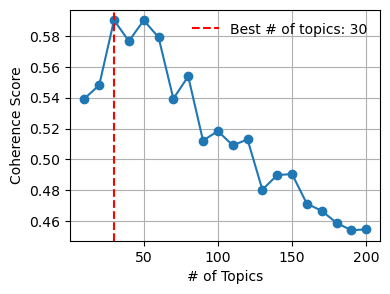

In [27]:
fig_file = os.path.join('/home/lyuzhuoqi/projects/clustering/data/2010s/topic_consistency', f'coherence_scores.pdf')
results_df = pd.read_csv('/home/lyuzhuoqi/projects/clustering/data/2010s/topic_consistency/topic_number_results.csv', index_col='num_topics')
best_topic_num = results_df.coherence.idxmax()

plt.figure(figsize=(4, 3))
plt.plot(results_df.index, results_df['coherence'], marker='o', linestyle='-',)
plt.axvline(x=best_topic_num, color='red', linestyle='--', label=f'Best # of topics: {best_topic_num}')
plt.xlabel('# of Topics')
plt.ylabel('Coherence Score')
plt.legend(frameon=False)
plt.grid(True)
plt.savefig(fig_file, dpi=300, bbox_inches='tight')

# Training a (or loading a trained) LDA model

In [5]:
# ‰ΩøÁî®ÊúÄ‰ºò‰∏ªÈ¢òÊï∞ÈáèÈáçÊñ∞ÂàùÂßãÂåñÂàÜÊûêÂô®
analyzer.num_topics = 30
analyzer.train_lda_model(multicore=False, save_dir='periodical-clustering/data/2010s/topic_consistency')

2025-05-26 13:59:15,444 : INFO : ÊâæÂà∞Â∑≤ÊúâÊ®°ÂûãÊñá‰ª∂ÔºåÊ≠£Âú®Âä†ËΩΩ...


2025-05-26 13:59:15,733 : INFO : Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºöperiodical-clustering/data/2010s/topic_consistency/lda_model_30topics.model


In [6]:
# Print top 20 words for first 5 topics as examples
print("Example Topics from LDA Model:")
for topic_id in range(5):  # Show first 5 topics
    # Get the top 20 words for this topic
    top_words = [word for word, _ in analyzer.lda_model.show_topic(topic_id, topn=20)]
    print(f"\nTopic {topic_id}:")
    # Display 5 words per line
    for i in range(0, len(top_words), 5):
        print(", ".join(top_words[i:i+5]))

Example Topics from LDA Model:

Topic 0:
surface, two, velocity, flow, formation
along, depth, length, layer, within
region, vertical, thickness, zone, angle
field, large, distance, position, area

Topic 1:
soil, plant, content, plants, growth
production, water, study, yield, higher
total, showed, increased, different, organic
biomass, treatment, results, iron, concentrations

Topic 2:
water, species, areas, data, area
changes, climate, study, population, change
period, region, china, may, sites
high, spatial, distribution, environmental, years

Topic 3:
fiber, fibers, 2010, 2011, 2012
dental, 2013, wiley, silica, 2014
annealing, oral, copyright, 2015, cutting
2009, van, john, teeth, reserved

Topic 4:
cells, cell, expression, protein, role
human, proteins, mice, activation, signaling
also, receptor, activity, pathway, growth
mechanisms, cellular, results, response, function


# Consistency analysis

In [9]:
analyzer.prepare_dataset()

2025-05-26 14:05:57,532 : INFO : ÊâæÂà∞Â∑≤Â§ÑÁêÜÁöÑPaperID listÔºåÊ≠£Âú®Âä†ËΩΩ: /home/zqlyu2/projects/periodical-clustering/data/2010s/classification_tasks/abstracts/valid_PaperID.json
2025-05-26 14:06:00,566 : INFO : Preparing dataset...
2025-05-26 14:06:01,915 : INFO : Created DataFrame with 23322430 rows
2025-05-26 14:06:01,916 : INFO : Loading label files...
2025-05-26 14:06:01,917 : INFO : Loading cocm_n2v_kmeans_label...
2025-05-26 14:07:11,793 : INFO : Loading cm_n2v_kmeans_label...
2025-05-26 14:08:20,539 : INFO : Loading gnn_kmeans_label...
2025-05-26 14:09:29,828 : INFO : Loading scopus_label...
2025-05-26 14:10:51,915 : INFO : Loading cm_kmeans_label...
2025-05-26 14:12:01,725 : INFO : Loading skm_label...
2025-05-26 14:13:15,395 : INFO : Loading kmeans_label...
2025-05-26 14:14:25,719 : INFO : Loading bert_kmeans_label...
2025-05-26 14:15:39,309 : INFO : Loading cocm_kmeans_label...
2025-05-26 14:16:49,252 : INFO : Loading movmf_label...
2025-05-26 14:18:15,007 : INFO : Êï∞

PaperID  cocm_n2v_kmeans_label  cm_n2v_kmeans_label  \
0         2055207701                     11                    2   
1         2055207717                     11                    1   
2         2055207742                      2                   25   
3         2055207772                      2                   10   
4         2055207790                     11                   20   
...              ...                    ...                  ...   
23322425  2726882176                      8                    3   
23322426  2726882179                      2                   22   
23322427  2726882219                      5                    4   
23322428  2726882240                      2                   25   
23322429  2726882392                      0                   24   

          gnn_kmeans_label                          scopus_label  \
0                        8  Agricultural and Biological Sciences   
1                       11                              Medicine   
2                        5                       Social Sciences   
3                       11                              Medicine   
4                        0           Immunology and Microbiology   
...                    ...                                   ...   
23322425                 0                     Multidisciplinary   
23322426                12                       Social Sciences   
23322427                 2                     Materials Science   
23322428                12   Business, Management and Accounting   
23322429                 1                           Engineering   

          cm_kmeans_label  skm_label  kmeans_label  bert_kmeans_label  \
0                       1         17             8                 13   
1                      23         14             7                 15   
2                       1         25            23                 24   
3                       7          8            22                 21   
4                       4         23            16                 13   
...                   ...        ...           ...                ...   
23322425               21         20            17                  0   
23322426                1          4            24                 16   
23322427                6         12            14                  9   
23322428                1          4             1                 16   
23322429                1         11             5                 20   

          cocm_kmeans_label  movmf_label  
0                        25           13  
1                        16           15  
2                         1           19  
3                        15            8  
4                         8           22  
...                     ...          ...  
23322425                  8           22  
23322426                 12            2  
23322427                 23           23  
23322428                 12            2  
23322429                 20            3  

[23322430 rows x 11 columns]

2025-05-26 14:19:56,384 : INFO : ‰∏ªÈ¢òÂàÜÂ∏ÉÊñá‰ª∂Ë∑ØÂæÑ: periodical-clustering/data/2010s/topic_consistency/topic_distributions_30topics.npy
2025-05-26 14:19:56,385 : INFO : ÊâæÂà∞Â∑≤Êúâ‰∏ªÈ¢òÂàÜÂ∏ÉÊñá‰ª∂ÔºåÊ≠£Âú®Âä†ËΩΩ...


2025-05-26 14:19:58,369 : INFO : ‰∏ªÈ¢òÂàÜÂ∏ÉÂä†ËΩΩÊàêÂäü
2025-05-26 14:19:59,817 : INFO : 
Analyzing kmeans_label...
2025-05-26 14:21:38,868 : INFO : ËÅöÁ±ªÂõæÂ∑≤‰øùÂ≠òËá≥: periodical-clustering/data/2010s/topic_consistency/topic_label_matrix_kmeans_label.pdf
2025-05-26 14:21:38,870 : INFO : 
Analyzing cm_kmeans_label...
2025-05-26 14:23:24,168 : INFO : ËÅöÁ±ªÂõæÂ∑≤‰øùÂ≠òËá≥: periodical-clustering/data/2010s/topic_consistency/topic_label_matrix_cm_kmeans_label.pdf
2025-05-26 14:23:24,169 : INFO : 
Analyzing cm_n2v_kmeans_label...
2025-05-26 14:25:05,121 : INFO : ËÅöÁ±ªÂõæÂ∑≤‰øùÂ≠òËá≥: periodical-clustering/data/2010s/topic_consistency/topic_label_matrix_cm_n2v_kmeans_label.pdf
2025-05-26 14:25:05,123 : INFO : 
Analyzing cocm_kmeans_label...
2025-05-26 14:26:44,771 : INFO : ËÅöÁ±ªÂõæÂ∑≤‰øùÂ≠òËá≥: periodical-clustering/data/2010s/topic_consistency/topic_label_matrix_cocm_kmeans_label.pdf
2025-05-26 14:26:44,772 : INFO : 
Analyzing cocm_n2v_kmeans_label...
2025-05-26 14:28:24,992 : INFO 

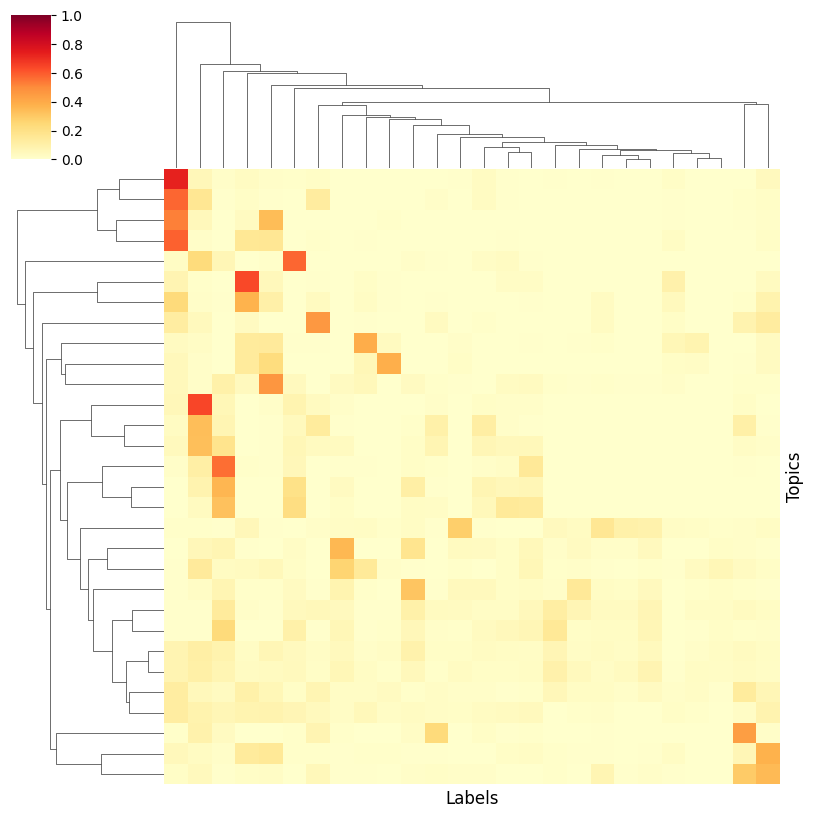

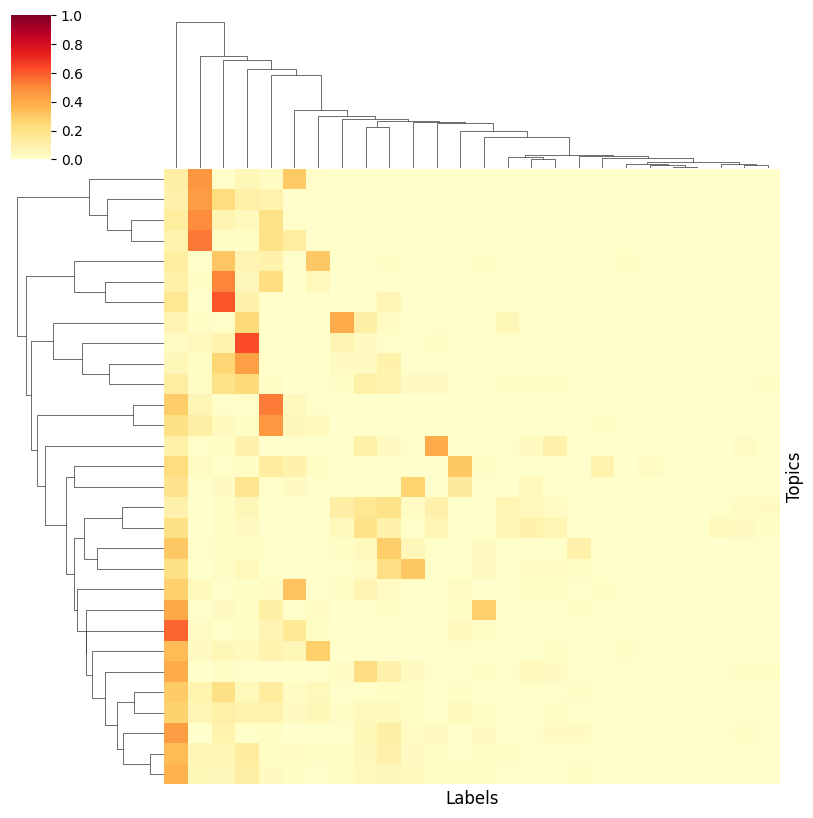

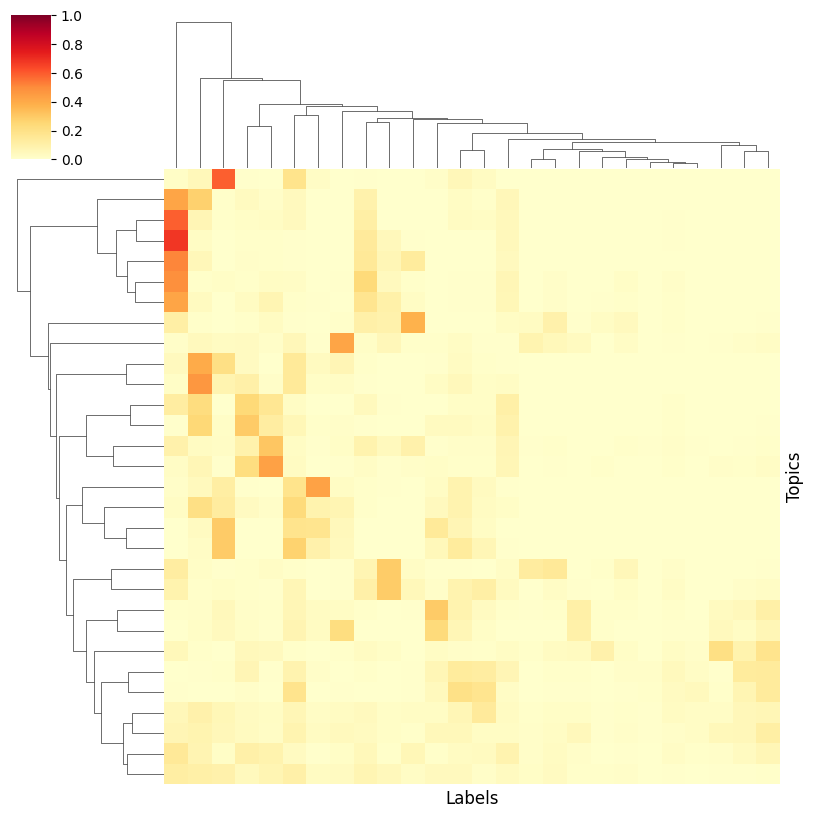

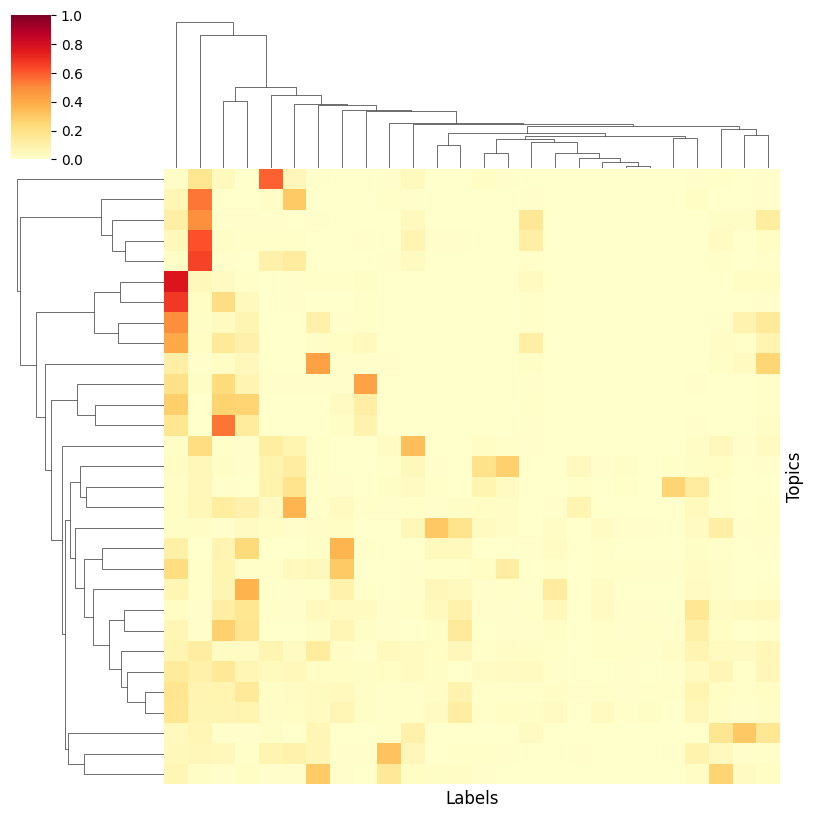

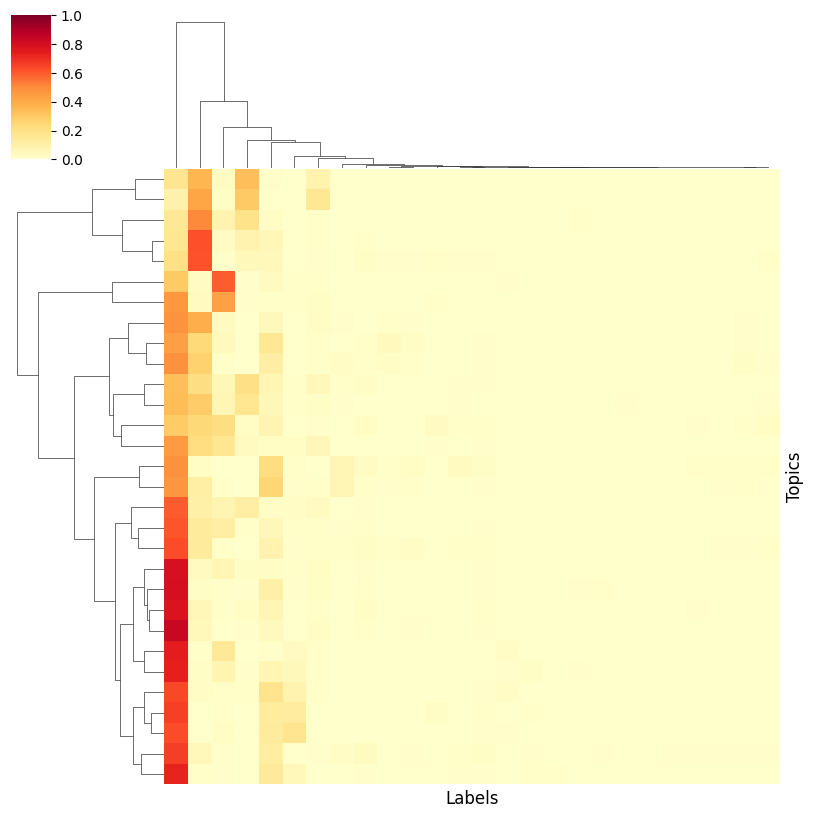

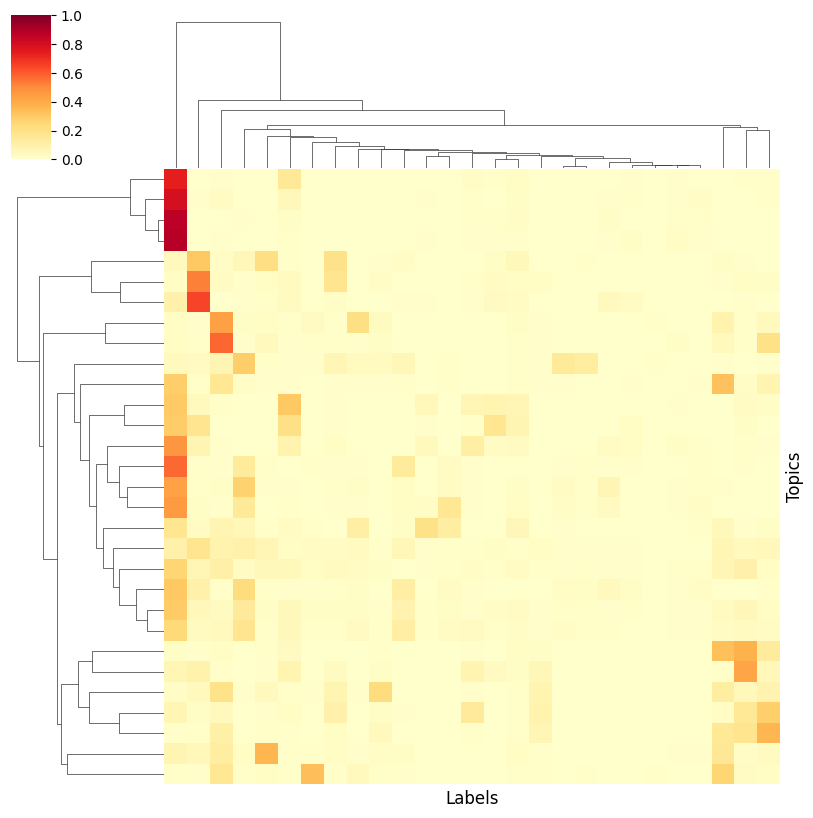

In [10]:
# ÂàÜÊûêÊâÄÊúâÊ†áÁ≠æÁ±ªÂûã
label_to_method = {
            'kmeans_label': 'Periodical2Vec+$k$-means',
            # 'skm_label': 'Periodical2Vec+Sperical $k$-means',
            # 'movmf_label': 'Periodical2Vec+movMF',
            # 'bert_kmeans_label': 'BERT+$k$-means',
            'cm_kmeans_label': 'Citation Matrix+$k$-means',
            'cm_n2v_kmeans_label': 'Node2Vec+$k$-means',
            'cocm_kmeans_label': 'Co-Citation Matrix+$k$-means',
            'cocm_n2v_kmeans_label': 'Co-Citation Node2Vec+$k$-means',
            # 'gnn_kmeans_label': 'GNN+$k$-means',
            'scopus_label': 'Scopus'
        }
results = analyzer.analyze_all_label_types(label_to_method)

In [11]:
# Êü•ÁúãÁâπÂÆöÊ†áÁ≠æÁ±ªÂûãÁöÑÁªìÊûú
for label_type, metrics in results.items():
    print(f"\n{analyzer.label_to_method[label_type]}ÁöÑ‰∏ÄËá¥ÊÄßÊåáÊ†á:")
    print(f"Ê†áÂáÜÂåñ‰∫í‰ø°ÊÅØ: {metrics['normalized_mutual_information']:.4f}")
    print(f"Ë∞ÉÊï¥ÂÖ∞Âæ∑ÊåáÊï∞: {metrics['adjusted_rand_index']:.4f}")
    print(f"Fowlkes-MallowsÊåáÊï∞: {metrics['fowlkes_mallows_index']:.4f}")
    


Periodical2Vec+$k$-meansÁöÑ‰∏ÄËá¥ÊÄßÊåáÊ†á:
Ê†áÂáÜÂåñ‰∫í‰ø°ÊÅØ: 0.3195
Ë∞ÉÊï¥ÂÖ∞Âæ∑ÊåáÊï∞: 0.1693
Fowlkes-MallowsÊåáÊï∞: 0.2169

Citation Matrix+$k$-meansÁöÑ‰∏ÄËá¥ÊÄßÊåáÊ†á:
Ê†áÂáÜÂåñ‰∫í‰ø°ÊÅØ: 0.2662
Ë∞ÉÊï¥ÂÖ∞Âæ∑ÊåáÊï∞: 0.1127
Fowlkes-MallowsÊåáÊï∞: 0.1804

Node2Vec+$k$-meansÁöÑ‰∏ÄËá¥ÊÄßÊåáÊ†á:
Ê†áÂáÜÂåñ‰∫í‰ø°ÊÅØ: 0.2748
Ë∞ÉÊï¥ÂÖ∞Âæ∑ÊåáÊï∞: 0.1306
Fowlkes-MallowsÊåáÊï∞: 0.1816

CoCitation Matrix+$k$-meansÁöÑ‰∏ÄËá¥ÊÄßÊåáÊ†á:
Ê†áÂáÜÂåñ‰∫í‰ø°ÊÅØ: 0.3168
Ë∞ÉÊï¥ÂÖ∞Âæ∑ÊåáÊï∞: 0.1633
Fowlkes-MallowsÊåáÊï∞: 0.2203

CoCitation Node2Vec+$k$-meansÁöÑ‰∏ÄËá¥ÊÄßÊåáÊ†á:
Ê†áÂáÜÂåñ‰∫í‰ø°ÊÅØ: 0.1672
Ë∞ÉÊï¥ÂÖ∞Âæ∑ÊåáÊï∞: 0.0324
Fowlkes-MallowsÊåáÊï∞: 0.1631

ScopusÁöÑ‰∏ÄËá¥ÊÄßÊåáÊ†á:
Ê†áÂáÜÂåñ‰∫í‰ø°ÊÅØ: 0.3010
Ë∞ÉÊï¥ÂÖ∞Âæ∑ÊåáÊï∞: 0.1371
Fowlkes-MallowsÊåáÊï∞: 0.2106
